In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('./pruebillas.ipynb'), '..'))
os.chdir(root_dir)

sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import pandas as pd
from get_data import get_data
import pytz
from datetime import datetime
import talib as ta
import random
from backbone.trader_bot import TraderBot
random.seed(42)


In [6]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# get all symbols
symbols = mt5.symbols_get()


groups = []
for symbol in symbols:
    group = symbol.path.split('\\')[0]
    if not group in groups:
        groups.append(group)
groups


['Forex_Indicator',
 'CryptoCross_grp',
 'Crypto_group',
 'Energies_group',
 'Forex_group',
 'Indices_group',
 'Stocks_group']

In [7]:

tickers = [symbol.path.split('\\')[1] for symbol in symbols if 'Forex_group' in symbol.path and symbol.spread < 15]
print(tickers)


# Establecer la zona horaria a UTC
timezone = pytz.timezone("Etc/UTC")

# Crear objetos 'datetime' en zona horaria UTC
date_from = datetime(2021, 10, 1, tzinfo=timezone)
date_to = datetime(2023, 1, 1, tzinfo=timezone)

intervals = [
    # mt5.TIMEFRAME_M1,
    # mt5.TIMEFRAME_M2,
    # mt5.TIMEFRAME_D1,
    # mt5.TIMEFRAME_M3,
    # mt5.TIMEFRAME_M4,
    # mt5.TIMEFRAME_M5,
    mt5.TIMEFRAME_M15,
    mt5.TIMEFRAME_M30,
    mt5.TIMEFRAME_H1,
    mt5.TIMEFRAME_M30,
]

symbols = get_data(tickers, intervals, date_from, date_to)

['AUDUSDm', 'EURGBPm', 'EURUSDm', 'GBPUSDm', 'TRYDKKm', 'USDCHFm', 'USDJPYm']
MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
AUDUSDm
AUDUSDm
AUDUSDm
AUDUSDm
EURGBPm
EURGBPm
EURGBPm
EURGBPm
EURUSDm
EURUSDm
EURUSDm
EURUSDm
GBPUSDm
GBPUSDm
GBPUSDm
GBPUSDm
TRYDKKm
TRYDKKm
TRYDKKm
TRYDKKm
USDCHFm
USDCHFm
USDCHFm
USDCHFm
USDJPYm
USDJPYm
USDJPYm
USDJPYm


In [8]:
max_start_date = None
intervals_start_dates = {}

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date

intervals_start_dates



{15: Timestamp('2021-10-27 17:15:00'),
 30: Timestamp('2021-10-27 17:15:00'),
 16385: Timestamp('2021-10-27 17:15:00')}

In [9]:
class Macd(Strategy):
    risk=3

    def init(self):
        self.sma_200 = self.I(
            ta.SMA, self.data.Close, timeperiod=200
        )

        self.macd, self.macdsignal, self.macdhist = self.I(
            ta.MACD, 
            self.data.Close, 
            fastperiod=7, 
            slowperiod=26, 
            signalperiod=9
        )

        self.rsi = self.I(ta.RSI, self.data.Close, timeperiod=2)

    def next(self):
        actual_close = self.data.Close[-1]
        cum_rsi = self.rsi[-1] + self.rsi[-2]

        if self.position:
            first_trade = self.trades[0]

            first_trade_time = first_trade.entry_time
            if pd.api.types.is_datetime64_any_dtype(first_trade_time):
                if first_trade_time.tzinfo is None:
                    first_trade_time = first_trade_time

            today = self.data.index[-1]

            # Calcular el tiempo en la posición
            time_in_position = (today - first_trade_time).days

            if self.position.is_long:
                if cum_rsi > 75:
                    self.position.close()

            if self.position.is_short:
                if cum_rsi < 25:
                    self.position.close()

        else:

            if crossover(self.macdsignal, self.macd) and cum_rsi <= 25 and actual_close > self.sma_200:
                self.buy(size=self.risk / 100)
                
            if crossover(self.macd, self.macdsignal) and cum_rsi > 75 and actual_close < self.sma_200:
                self.sell(size=self.risk / 100)

In [10]:
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression


strategies = [
    Macd, 
]

experiments = parameter_combinations = list(itertools.product(
    tickers, intervals, strategies
))

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:

    start_date = intervals_start_dates[interval]

    bt_train = Backtest(
        symbols[ticker][interval].loc[start_date:], 
        strategy,
        commission=7e-4,
        cash=15_000, 
        margin=1/30
    )
    
    stats = bt_train.run()
    
    equity_curve = stats._equity_curve['Equity'].values    
    x = np.arange(len(equity_curve)).reshape(-1, 1)
    reg = LinearRegression().fit(x, equity_curve)
    stability_ratio = reg.score(x, equity_curve)

    df_stats = pd.DataFrame({
        'strategy':[strategy.__name__],
        'ticker':[ticker],
        'interval':[interval],
        'stability_ratio':[stability_ratio],
        'return':[stats['Return [%]']],
        'final_eq':[stats['Equity Final [$]']],
        'drawdown':[stats['Max. Drawdown [%]']],
        'drawdown_duration':[stats['Max. Drawdown Duration']],
        'win_rate':[stats['Win Rate [%]']], 
        'sharpe_ratio':[stats['Sharpe Ratio']],
        'trades':[stats['# Trades']],
        'avg_trade_percent':[stats['Avg. Trade [%]']],
        'exposure':[stats['Exposure Time [%]']],
        'final_equity':[stats['Equity Final [$]']],
        'Duration':[stats['Duration']],

    })

    performance = pd.concat([performance, df_stats])

performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)
performance.drawdown_duration = performance.drawdown_duration.dt.days



In [12]:

filter_performance = performance[
    (performance['return']>0) 
    # & (performance['return/dd']>=2) 
    # & (performance['stability_ratio'] > 0.9)
    # & (performance['interval'] <= 16385)
].sort_values(by=['custom_metric'], ascending=[False]).drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance)

# portfolio

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,Macd,TRYDKKm,30,0.583246,51.895220,22784.283071,28.373014,370,64.722222,0.813241,360,0.126600,42.159331,22784.283071,429 days 04:00:00,1.829034,10.404265
0,Macd,USDCHFm,16385,0.111321,0.785091,15117.763613,5.280567,264,62.962963,0.129299,135,0.006335,38.299320,15117.763613,428 days 12:00:00,0.148675,0.614097


In [9]:
mt5.TIMEFRAME_H1

16385

In [14]:
for ticker, interval in zip(portfolio, intervals):
    bt_train = Backtest(
        symbols[ticker][interval], 
        Macd,
        commission=7e-4,
        cash=15_000, 
        margin=1/30
    )

    stats = bt_train.run()

    bt_train.plot(filename=f'./{ticker}.html', resample=False)

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarn

## Stocks
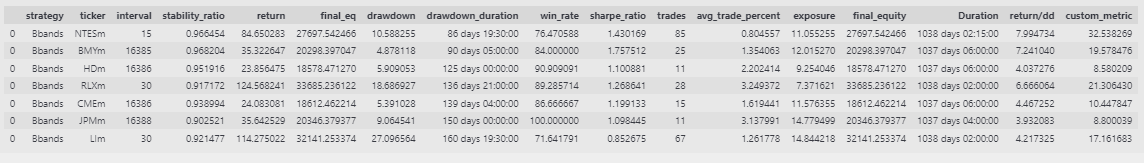


In [11]:
mt5.TIMEFRAME_H1

16385

In [15]:
# Crear objetos 'datetime' en zona horaria UTC
date_from = datetime(2021, 10, 1, tzinfo=timezone)
date_to = datetime(2024, 9, 1, tzinfo=timezone)

tickers = ['BBBYm']
intervals = [mt5.TIMEFRAME_H1]

symbols = get_data(tickers, intervals, date_from, date_to)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
BBBYm


In [16]:
from utils import walk_forward

def  optim_func(series):
    return (series['Return [%]'] /  (1 + (-1*series['Max. Drawdown [%]']))) * np.log(1 + series['# Trades'])


lookback_bars = 1920
validation_bars = 200
warmup_bars = 400

params = {
    'b_open_threshold' : [0.9, 0.95, 0.99],
    'b_close_threshold' : [0.5, 0.6, 0.8, 0.9],
    'maximize': optim_func
}

stats = walk_forward(
    Bbands,
    symbols['BBBYm'][16385], 
    lookback_bars=lookback_bars,
    validation_bars=validation_bars,
    warmup_bars=warmup_bars, 
    params=params,
    commission=7e-4, 
    margin=1/30, 
    cash=15_000
)

  0%|          | 0/12 [00:00<?, ?it/s]

equity final: 19813.812702


  0%|          | 0/12 [00:00<?, ?it/s]

equity final: 26119.899344999998


  0%|          | 0/12 [00:00<?, ?it/s]

equity final: 33485.295787999996


  0%|          | 0/12 [00:00<?, ?it/s]

equity final: 44495.12951099999


  0%|          | 0/12 [00:00<?, ?it/s]

equity final: 54105.979686999985


  0%|          | 0/12 [00:00<?, ?it/s]

equity final: 68249.29086199998


  0%|          | 0/12 [00:00<?, ?it/s]

equity final: 86296.14985599997


  0%|          | 0/12 [00:00<?, ?it/s]

equity final: 99984.84613599996


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


In [17]:
from utils import plot_full_equity_curve

plot_full_equity_curve(
    symbols['BBBYm'][16385], 
    stats, 
    warmup_bars=warmup_bars,
    lookback_bars=lookback_bars, 
    overlay_price=True
)

In [20]:
from utils import get_wfo_stats

wfo_stats = get_wfo_stats(stats, warmup_bars, symbols['BBBYm'][16385])

for k, v in wfo_stats.items():
    print(k, v)
    

Start 2021-10-27 17:00:00
End 2023-05-02 19:00:00
Duration 552 days 02:00:00
Exposure Time [%] 10.892710892710893
Equity Final [$] 99984.84613599996
Equity Peak [$] 99984.84613599996
Return [%] 504.4906485397618
Buy & Hold Return [%] -99.49164851125634
Return (Ann.) [%] 1514.4994026639804
Volatility (Ann.) [%] 1859.2911338604765
Sharpe Ratio 0.8145574273349008
Sortino Ratio 33.19185767243578
Calmar Ratio 39.39889069016701
Max. Drawdown [%] -38.44015341888705
Avg. Drawdown [%] -6.833765139118529
Max. Drawdown Duration 20 days 03:00:00
Avg. Drawdown Duration 4 days 01:00:00
# Trades 23
Win Rate [%] 100.0
Best Trade [%] 17.625264514428384
Worst Trade [%] 1.1593127474244347
Avg. Trade [%] 9.54132358679547
Max. Trade Duration 10 days 00:00:00
Avg. Trade Duration 4 days 14:00:00
Profit Factor nan
Expectancy [%] 9.677322374776018
SQN 4.867110603052378
